In [4]:
import os
import sys
import random

import torch
torch.set_float32_matmul_precision('medium')
import torch.nn as nn
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from PIL import Image
from torchvision import models, transforms
import torchvision.transforms as T

from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_absolute_error, mean_squared_error

import tensorboard

sys.path.append('/glade/u/home/joko/ice3d')
from models.mlp_regression import MLPRegression

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
from data.tabular_datamodule import TabularDataModule
from data.tabular_dataset import TabularDataset
import json


# MLP

## Classification

In [5]:
tabular_file = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/tabular-data-v2/ros-tabular-data.parquet'
feature_names = ['aspect_ratio','aspect_ratio_elip','extreme_pts','contour_area','contour_perimeter','area_ratio','complexity','circularity']
target_names = ['n_arms']
batch_size = 128
subset_size = 0.1  
seed = 666
num_workers = 18
task_type = 'classification'
# Load the class mapping from a JSON file
class_mapping_file = '/glade/u/home/joko/ice3d/data/class_to_idx.json'
# Load class mapping from JSON file
with open(class_mapping_file, 'r') as f:
    class_to_idx = json.load(f)
def log_transform(x):
    return torch.log(x)

dm = TabularDataModule(
    data_file=tabular_file,
    feature_names=feature_names,
    target_names=target_names,
    batch_size=batch_size,
    subset_size=subset_size,
    subset_seed=seed,
    num_workers=num_workers,
    task_type=task_type,
    class_to_idx=class_to_idx,
    target_transform=log_transform,
    train_idx=None,
    val_idx=None,   
    test_idx=None
    )
dm.setup()


KeyboardInterrupt: 

Index(['epoch', 'step', 'train_loss', 'val_loss'], dtype='object')


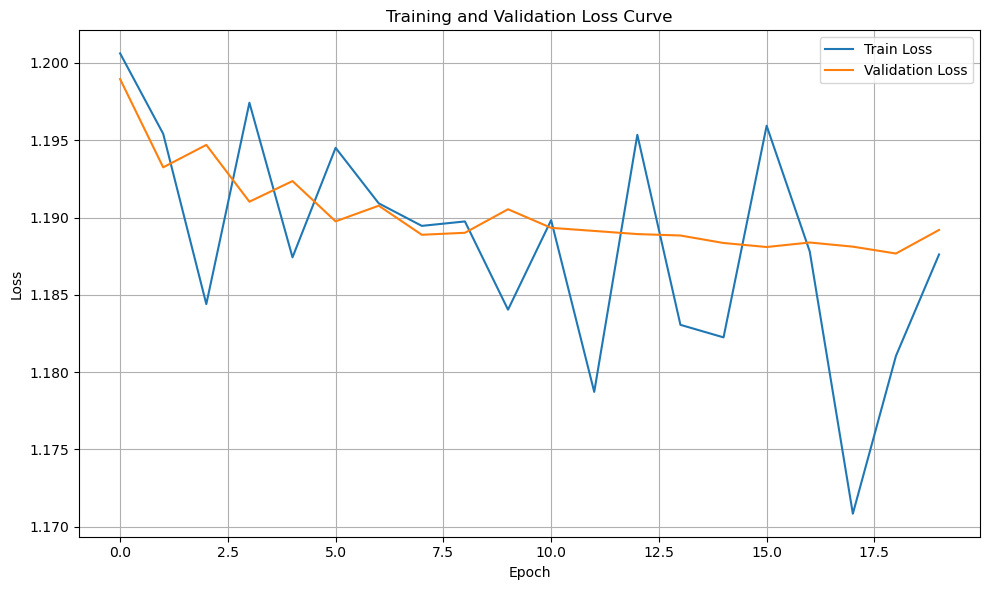

In [7]:
# plot loss curve
log_path = '/glade/u/home/joko/ice3d/models/lightning_logs/mlp-classification-subset-csv/version_10/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# load model and validate on val set
ckpt_path = '/glade/u/home/joko/ice3d/models/lightning_logs/mlp-classification-subset-csv/version_10/checkpoints/epoch=19-step=114860.ckpt'
model = MLPRegression.load_from_checkpoint(ckpt_path)
model.eval()
val_loader = dm.val_dataloader()
y_true = []
y_pred = []
for batch in val_loader:
    x, y = batch
    y_hat = model(x)
    y_true.append(y)
    y_pred.append(y_hat)
y_true = torch.cat(y_true).cpu().numpy()
y_pred = torch.cat(y_pred).cpu().numpy()
# use class mapping to get the class labels
y_true = [list(class_to_idx.keys())[list(class_to_idx.values()).index(int(y))] for y in y_true]
y_pred = [list(class_to_idx.keys())[list(class_to_idx.values()).index(int(y))] for y in y_pred]
# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(class_to_idx.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_idx.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
# calculate accuracy
accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f'Accuracy: {accuracy:.4f}')
# calculate f1-score    
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1-score: {f1:.4f}')